## UCL COMP0029 Individual Project for Year 3 BSc
### Robust Robotic Grasping Utilising Touch Sensing - Baseline Approach Notebook
This notebook contains the essential code for training and testing a supervised baseline approach to grasping. Given some tactile data, end effector poses, etc., it determines whether these constraints will produce a successful/unsuccessful grasp.

### 1. Load packages

In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split

Set device for `PyTorch` training

In [2]:
# Use GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### 2. Load datasets

Two datasets have been prepared from running the "collect sensory data" in the Pybullet simulation. These datasets are:
- `poses_ds.npy` that stores random 6d end effector poses generated by applying gaussian noise a manually selected base pose
- `training_ds.npy` that stores the tactile reading data collected from the DIGIT tactile sensors in the Pybullet simulation

The collected datasets are stored in `np.ndarray`s in a `.npy` file.

In [3]:
depth_ds_file_path = "depth_ds.npy"
depth_ds = np.load(depth_ds_file_path)
print(f"Shape of depth_ds: {depth_ds.shape}")

color_ds_file_path = "color_ds.npy"
color_ds = np.load(color_ds_file_path)
print(f"Shape of color_ds: {color_ds.shape}")

poses_ds_file_path = "poses_ds.npy"
poses_ds = np.load(poses_ds_file_path)
print(f"Shape of poses_ds: {poses_ds.shape}")

grasp_outcomes_ds_file_path = "grasp_outcomes.npy"
grasp_outcomes_ds = np.load(grasp_outcomes_ds_file_path)
print(f"Shape of grasp_outcomes_ds: {grasp_outcomes_ds.shape}")

Shape of depth_ds: (2763, 2, 160, 120)
Shape of color_ds: (2763, 2, 160, 120, 3)
Shape of poses_ds: (2763, 6)
Shape of grasp_outcomes_ds: (2763,)


In [4]:
### Check the number of successes and failures in the dataset
success = 0
failure = 0

for row in grasp_outcomes_ds:
    if row == 1:
        success += 1
    elif row == 0:
        failure += 1

print(f"Successes: {success} | Failures: {failure}")

Successes: 1264 | Failures: 1499


We can treat the depth and color images of each finger's sensor as separate or concatenated images. In this notebook, we will simply use the images separately.

Visualising random tactile data:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

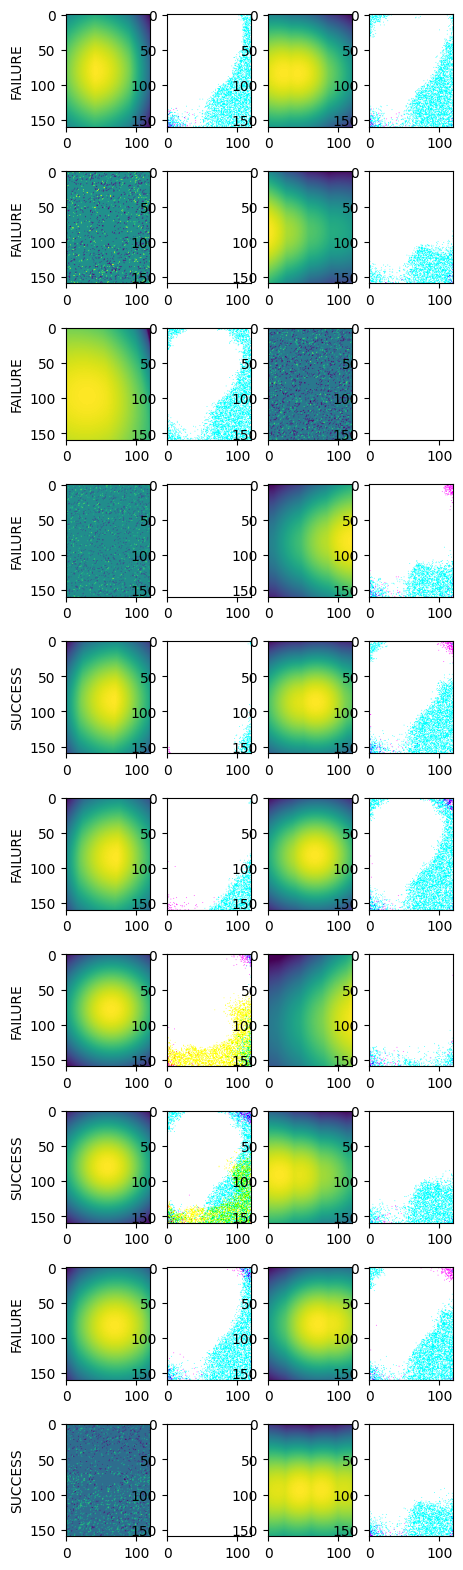

In [5]:
import matplotlib.pyplot as plt


rand_indices = np.random.choice(len(depth_ds), size=10)
cols = 4
rows = 10
fig = plt.figure(figsize=(5, 20))

for i in range(rows*cols):
    fig.add_subplot(rows, cols, i+1)
    if i % 4 == 0:
        plt.ylabel("SUCCESS" if grasp_outcomes_ds[i//4] == 1 else "FAILURE")
        plt.imshow(depth_ds[rand_indices[i//4]][0])
    elif i % 4 == 1:
        plt.imshow(color_ds[rand_indices[i//4]][0])
    elif i % 4 == 2:
        plt.imshow(depth_ds[rand_indices[i//4]][1])
    else:
        plt.imshow(color_ds[rand_indices[i//4]][1])

### 3. Principal Component Analysis w/ Logistic Regression

We first extract the top 3 eigenvectors of each image.

In [12]:
from skimage.transform import resize


def pca(X, ndims):
    """
    @params X: data matrix
    @params ndims: number of principal components to extract
    """
    
    # Flatten the image into a 1D array
    flat_X = np.asarray([img.flatten() for img in X])
    print(f"flat_X shape: {flat_X.shape}")

    # Perform PCA on the flattened image
    mean_imgs = np.mean(flat_X, axis=0)
    centered_X = flat_X - mean_imgs
    cov_matrix = np.cov(centered_X, rowvar=False)
    # eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

    # Sort the eigenvalues in decreasing order
    # idx = np.argsort(eigenvalues)[::-1]
    # eigenvalues = eigenvalues[idx]
    # eigenvectors = eigenvectors[:,idx]

    # # Keep only the top 3 eigenvectors
    # top_eigenvectors = eigenvectors[:, :ndims]

    # # Project the image onto the 3 eigenvectors
    # projected_X = np.dot(centered_X, top_eigenvectors)

    # # Reconstruct the image using the top 3 eigenvectors
    # reconstructed_X = np.dot(projected_X, top_eigenvectors.T) + mean_imgs
    # return reconstructed_X

In [13]:
pca_depth_ds = pca(depth_ds, 3)
pca_depth_ds.shape

flat_X shape: (2763, 38400)


: 

: 